In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

# Overscan/Flats
###### possibly do bias later but may have enough s/n without

In [2]:
#setups for later - dataoutput sizes

#changing plt default fig size to better show spectrums when i get that far
plt.rcParams['figure.figsize'] = (16, 10)

#setting up dimensions based on ccd size per specs on website
redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

In [3]:
#removing overscan from flats - RED SIDE

#'DomeFlat' is an object label telling it to look for
#tells to run reduce_dblspec on last 10 files ending in filename ext (with *)
rflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat','20170518/red*.fits')[:10]]

#creating normalized flats - ie just instrument noise not from readout
rnfl = reduce_dblspec.create_normalized_flat(rflats)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


In [4]:
#removing overscan from flats - BLUE SIDE


bflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat','20170518/blue*.fits')[:10]]
bnfl = reduce_dblspec.create_normalized_flat(bflats)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


In [5]:
rnfl
#rflats

array([[ 17.56308623,  12.76000184,  10.59112815, ...,   1.82912156,
          1.82161327,   1.81126631],
       [ -0.60534233,  -0.63664839,  -0.53548608, ...,   0.26530837,
          0.26663231,   0.27932067],
       [  0.77284575,   0.43265329,   0.42398356, ...,   0.39877516,
          0.3829107 ,   0.40949259],
       ..., 
       [  0.01847568,  -0.16568817,  -0.03793974, ...,   0.29037945,
          0.30046704,   0.32053848],
       [ -0.0196347 ,  -0.13300859,  -0.08069812, ...,   0.29019603,
          0.30058262,   0.31799273],
       [  0.0443154 ,  -0.03997535,  -0.09393531, ...,   0.31069659,
          0.29504021,   0.30747115]])

##### wheres combine exposures / rejecting cosmics step? maybe dont really need unless spot in a spectra somewhere crucial 

## Dispersion Solutions

#### Procedure:

#### 1. create a `DispersionSolution` object with the relvant arc
#### 2. compare to the atlas and match up lines
#### 3. use guess_plot to refine the line location (and ID the line list wl)
#### 4. once enough are populated, use `guess_from_line_list` to get the remainder

In [6]:
#wait this fcn is created in NB but never used - why? - work on understanding it later then


#creating a fcn that will guess the matching line peaks btwn (arcs or data?) & atlas
#guessing plot btwn pixels and wavelength
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec()
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas)
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists
    
#use e.g. guess_plot(3372, 9658, (rds, redwlnoao, redspecnoao, reduce_dblspec.HENEAR_LINE_LIST))

In [7]:
#Redside cam setup

#opening and locating the HeNeAr well know spec lines via noao spectral atlas files
redatlas = fits.open('henear.fits') #NOAO atlas
h = redatlas[0].header
redspecnoao = redatlas[0].data #these arent wavelengths but strength values per wavelength or less BUT 
#still not in order according to plots on noao so idk

#maybe matching atlas known spec lines to true wavelength - see more info in comments on blueside cam
redwlnoao = h['CRVAL1'] + h['CD1_1']*(np.arange(len(redspecnoao)) - h['CRPIX1'] + 1) #+1 is for 0-based
#CRVAL1 = 3296.2763671875 & this is the value in angstroms of the first pixel
#CD1_1 = 0.34725826978683 & this is the value in pixels of the first pixel
#CRPIX1 = 1. & this is the number of angstroms each pixel is from the previous pixel

h
#len(redspecnoao) #23642
#test = np.arange(len(redspecnoao)) 
#test #this is 0 to 23641
#max(redspecnoao) #30375928.0
#redspecnoao

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                  -32  /  FITS BITS/PIXEL                              
NAXIS   =                    1  /  NUMBER OF AXES                               
NAXIS1  =                23642  /                                               
OBJECT  = 'henear 3500A'        /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '26-07-96'            /                                               
IRAFNAME= 'henear.spec'         /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           3.591000E3  /  DATA MAX                                     
IRAF-MIN=           7.530000E2  /  DATA MIN                                     
IRAF-BPX=                   32  /  DATA BITS/PIXEL                              
IRAFTYPE= 'REAL    '            /  PIXEL TYPE                                   
OBSERVAT= 'KPNO             

In [8]:
#Blueside cam setup

#opening and locating the FeAr well know spec lines via atlas
blueatlas = fits.open('fear.fits') #NOAO atlas
h = blueatlas[0].header
bluespecnoao = blueatlas[0].data 
#bluespecnoao #think this is the known spec lines but no order or units so....wavelength/separation/pixel??
#its a numpy array of floats len=39709 - 10s to 1,000,000s in values but in no order/pattern/trend


#maybe matching atlas known spec lines to wavelength
bluewlnoao = h['CRVAL1'] + h['CD1_1']*(np.arange(len(bluespecnoao)) - h['CRPIX1'] + 1) #+1 is for 0-based
##CRVAL1 is (3003.4624023437) & this is the value in angstroms of the first pixel
#CD1_1 is (0.2) & this is the value in pixels of the first pixel
#CRPIX1 is (1.) & this is the number of angstroms each pixel is from the previous pixel
#* ((putting spec values in order)-CRPIX1)
#those values are nice but idk what the CR or CD parts references
h

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                39709 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
IRAF-TLM= '16:22:18 (11/08/1999)' / Time of last modification                   
OBJECT  = 'FeAr 3200A'          /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '1999-08-13T20:58:24' /                                               
IRAFNAME= 'FeAr.spec'           /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000E0  /  DATA MIN                                     
IRAF-BPX=                   

## Red Dispersion (1.5")

#### Steps 1 & 2?

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Want to match lines for calibrating wavelengths - top is from atlas, bottom is an arc lamp


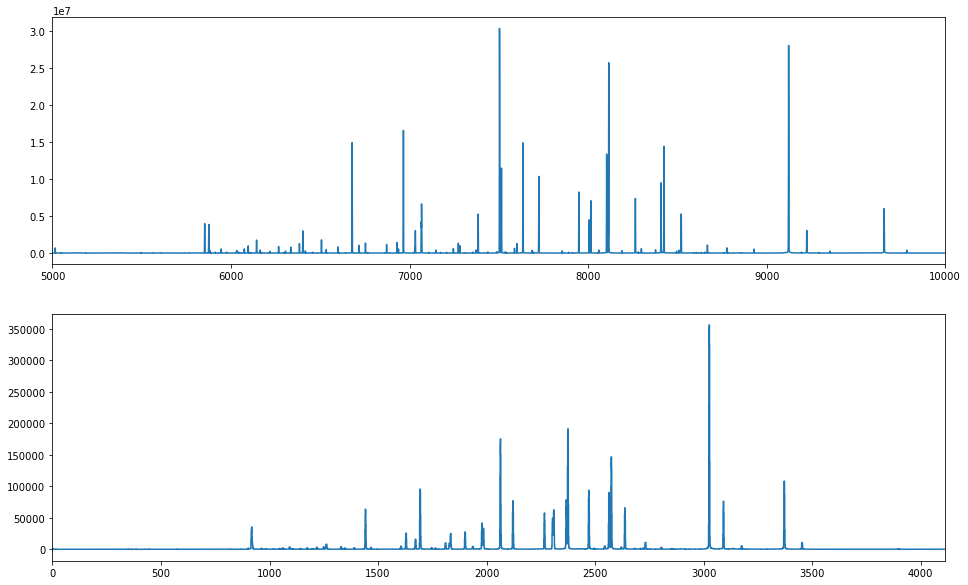

In [9]:
#first graph

#1D spec extraction from atlas lists/specs
fig, (ax1, ax2) = plt.subplots(2,1)#setting dimensions & locations of plots
ax1.plot(redwlnoao, redspecnoao) #atlas wl on x axis, atlas spec? on y axis
ax1.set_xlim(5000,10000) #x axis range to plot
#ax1.set_xlim(9115,9135) #only gives 1 decimal pt precison, couldnt get such exact numbers from this for guesslineloc


#second graph - 1st arc lamp

#extracts 1D spec from arcimag and outputs line pixel to wl
#this one line is doing a dispersion solution to the:
#((data) that has overscan subtraction and trimming done to it and image flattened w/ (created above,normalized flat-rnfl), aperaturesize)
rds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl), (320, 360))
plt.axes(ax2) #plotting what the above line did
rds.plot_spec() #orders the 1D spec outputted above and uses plt to plot
#plt.xlim(3000,3100)
print ('Want to match lines for calibrating wavelengths - top is from atlas, bottom is an arc lamp')



## Test to automate peak line detection

In [10]:
#trying to create a list of the top 10 peaks for atlas, then do similar for arcs then compare to match lines automatically
atlas_list=[]
for i in redspecnoao:
    atlas_list.append(i)
#max(mylist)
ordered_atlas = np.sort(atlas_list) #sorts small to large
topten = ordered_atlas[-10:] #last 10 aka the biggest values
print('ordered',topten)
#trying to get index numbers 
for i in atlas_list:
    if i >= (min(topten)): 
        print('stop here.................................')
    elif i <= (min(topten)):
        numbers = np.arange(0,23642)
        for i in numbers:
            print
    # if i in topten:

    #    print (i)
#x = np.arange(len(ordered_atlas))
#plt.plot(x,ordered_atlas)
##for i in ordered_atlas:
  ##  print (i)

ordered [ 18986596.  20629942.  23808928.  24614434.  24753024.  25061664.
  25731852.  28072980.  28801406.  30375928.]
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................
stop here.................................


In [11]:
for i in topten:
    print (i)

1.89866e+07
2.06299e+07
2.38089e+07
2.46144e+07
2.4753e+07
2.50617e+07
2.57319e+07
2.8073e+07
2.88014e+07
3.03759e+07


In [12]:
len(redspecnoao)

23642

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


(0, 4000)

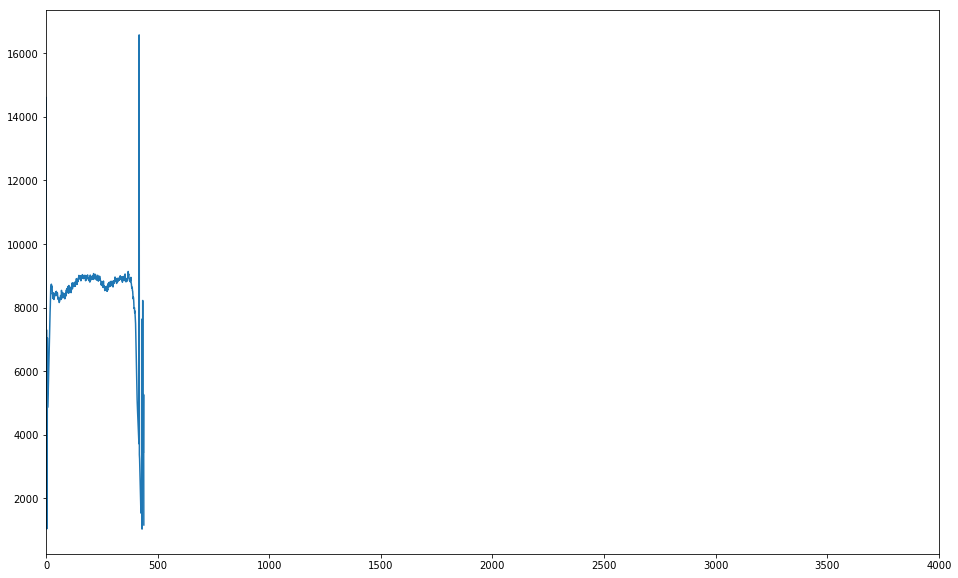

In [13]:
#reduce_dblspec.DispersionSolution?? #similar to help()  #can also do just ? for header info
file = (reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl), (320, 360))
arc_list = []
for row in file[0].data: #this is each pixel row's values across spectrum in the data part of the file
    maxs = max(row)
    arc_list.append(maxs) #collecting the max values from each row into a list
    
#ordered_arc = np.sort(arc_list) #dont need to do this yet
#ordered_arc
x = np.arange(439)
#x
#print(max(file[0].data[0])) #def the same thing
#print(arc_list[0]) #def the same thing
plt.plot(x,arc_list[1::])
plt.xlim(0,4000)    
#    for i in row: #each row is 4114
#        [i + (i+1) for x, y in zip(a, b)]

#print(test[0].data)

## End of test

In [14]:
#help(rds)
#rds.peak_stats(900)

#this gives errors b/c need slice integers
#guess_plot(3072, 9158, (rds, redwlnoao, redspecnoao, reduce_dblspec.HENEAR_LINE_LIST))
#help(round)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 0.9961512863913919, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0578827797865025, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, whi

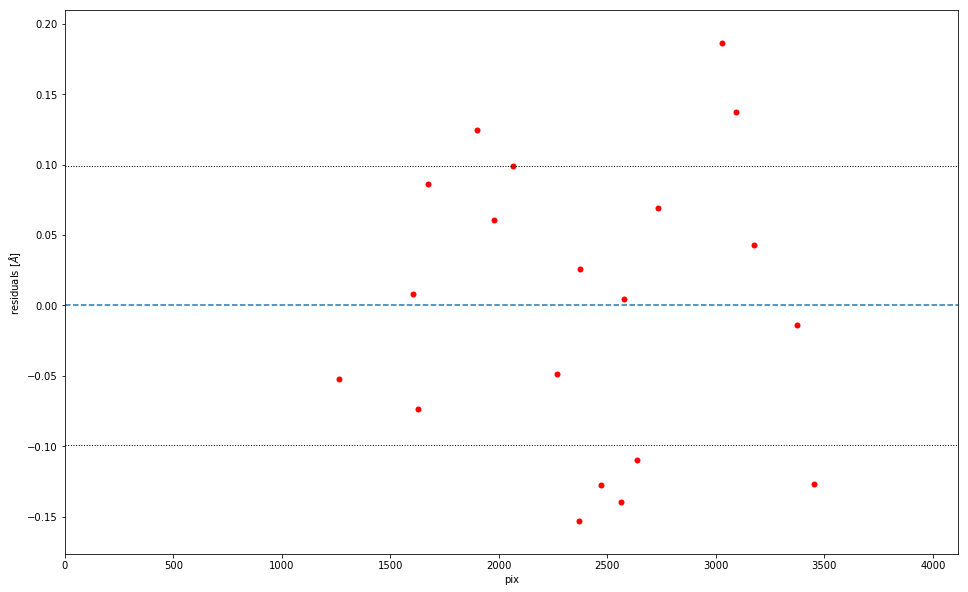

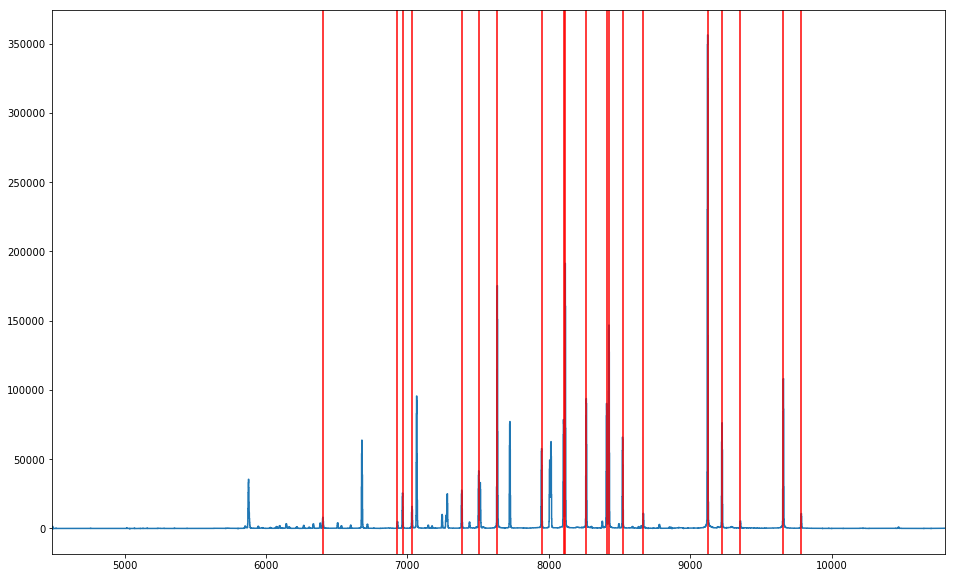

In [15]:
#exploring the module, must call module then class then fcn to see what fcn does - like tree branches need bases

#help(reduce_dblspec.DispersionSolution.overscan_sub_and_trim)
#help(reduce_dblspec.DispersionSolution)
#help(reduce_dblspec)
redarcimg15 = reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl)
rds = reduce_dblspec.DispersionSolution(redarcimg15, (320, 360), poly_order=3)


pixel_guesses = [3372,3027,2375,2065,1630]
#pixel_guesses = list(map(int, px_guesses))
atlas_lines = [9657.78,9122.9674,8115.31,7635.1,6965.43]

guesses = list(zip(pixel_guesses, atlas_lines))
#print (guesses[0][1])


''' 
px = []
al = []
for i in pixel_guesses:
    a = rds.guess_line_loc(i,atlas_lines)
    px.append(a[0])
    print ('this is px',px,'end px')
for r in atlas_lines:
            b = rds.guess_line_loc(i,r)
print (b)
'''
#rds.guess_line_loc(pixel_guesses,atlas_lines)
##for p in pixel_guesses:
##    for a in atlas_lines:
        #for a in atlas_lines:
##            output = rds.guess_line_loc(guesses)
##            outputs.append(output)
##            print(output)
outputs = []
for i in guesses:
    #print (i[0]) #first values for each tuple
    #print (i[1])
    list_a = rds.guess_line_loc(i[0], i[1])
    outputs.append(list_a)

rds.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
rds.plot_solution(True) #plotsdres=true -- think that displays dashed line as standard residuals value 
plt.figure()
rds.plot_spec_wl()


    
#outputs
    
#output = rds.guess_line_loc(guesses[0][0],guesses[0][1])
#output


#### Step 4   (guess_from_line_list)  &  step 3??? (but uses guess_line_loc not guess_plot)

In [16]:
#naming the overscanned & trimmed data image that is also flattened with prior created normalized flat
redarcimg15 = reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl)

#applying the dispersion solution to (above line data, aperature dimensions, fitting line with 3rd degree poly) 
rds = reduce_dblspec.DispersionSolution(redarcimg15, (320, 360), poly_order=3)

#want to guess line location(guess of pixel of peak line location, real wavelength of the line you think that is)
#returns slightly more accurate value for 1st input based on 2nd
rds.guess_line_loc(3372, 9657.78) #why these particular wavelengths/ what emission is this?
rds.guess_line_loc(3027, 9122.967)
rds.guess_line_loc(2375, 8115.31)
rds.guess_line_loc(2065, 7635.1)
rds.guess_line_loc(1630, 6965.43) 
#kinda confused by these b/c thought needs 4 inputs not 2-(minpeakrati, addtosoln) they dont seem necessary tho

#this runs thru atlas known spec lines & tries to match peaks to wl in specified range in ()
rds.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
#HENEAR_LINE_LIST is a list in reduce_dblspec module of wl values & associated element(s) name
#what is verbose?(wordiness?) - if it is output is found line
#how decided minpeakratio value-guess 10 is just a good low number but high enough to be above noise?
#peak to base ratio to do s/n (sigma) clip

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 1.70345742007994, which is less than 10"
Failed to find line HeI at wl=7281.349: "Guessed line's peak to base ratio is 7.14150308130225, which is less than 10"
Failed to find line ArI at wl=7353.293: "Tried to find peak at 1881.0085680568388 but it's in a valley, not a peak"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.4085618089519034, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.1803035773828703, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Failed to find line ArI at wl=7514.6518: "Guessed line's peak to base ratio is 6.515277897571644, which is less than 10"
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 1.954924185705863, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to 

(20, 108)

aligning these graphs to check for overlap - top is dispersion residuals after wl to pixel matching(red), bottom is arc spec(pixels)(blue) to dispersion (wavelength)(red)


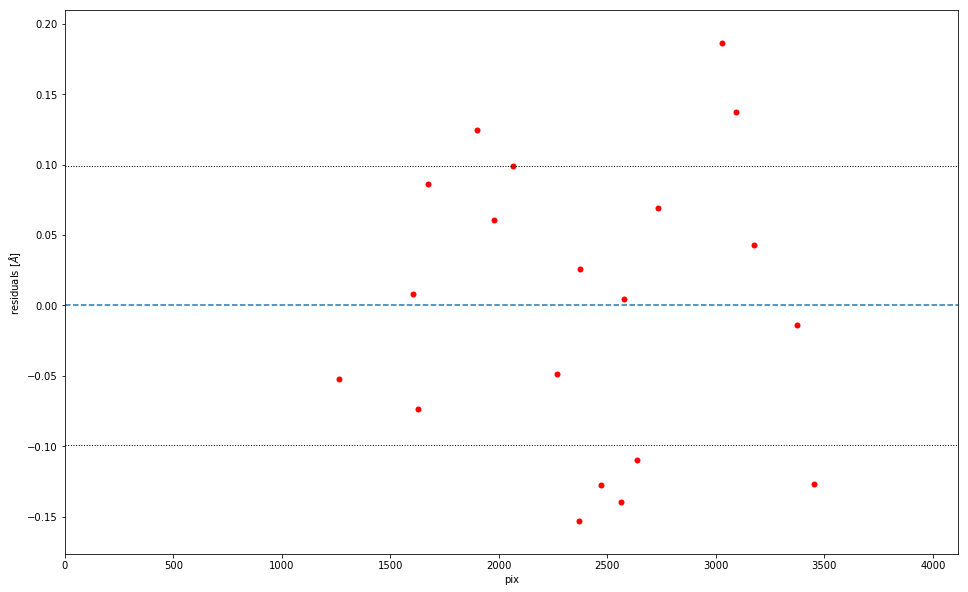

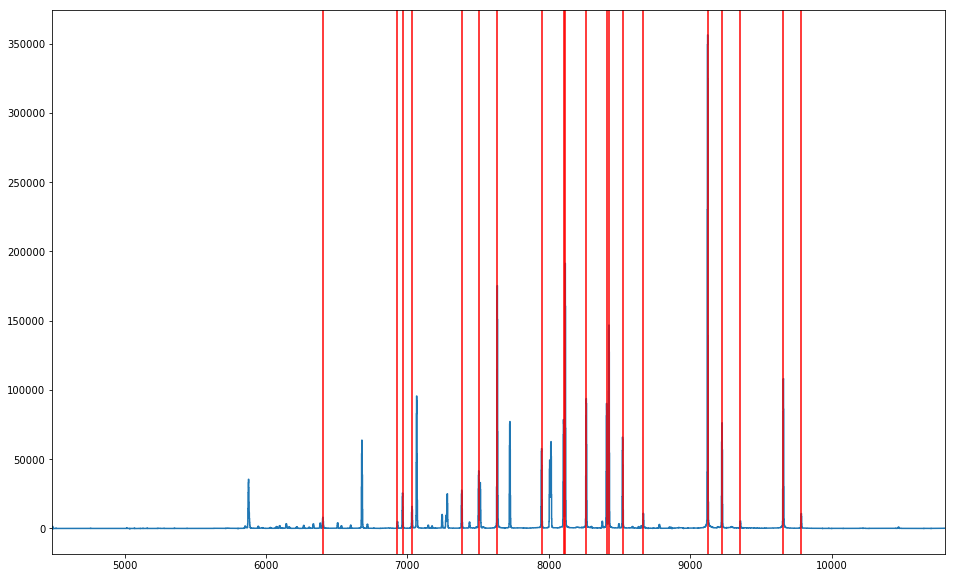

In [17]:
#1st graph
#need those guesses from guess_line_loc to run this
#scatter plots mins & maxs of red dispersion solution
rds.plot_solution(True) #plotsdres=true -- think that displays dashed line as standard residuals value 
plt.figure()

#2nd graph 
#plots 1D spec as a fcn of wavelength(blue) & dispersion min/maxs as red lines
rds.plot_spec_wl()

print ('aligning these graphs to check for overlap - top is dispersion residuals after wl to pixel matching(red), bottom is arc spec(pixels)(blue) to dispersion (wavelength)(red)')

# Collecting questions from this section
#### why choose these particular wavelengths/ what emissions are those / how determined guess values in 'guess_line_loc'?


## Red Dispersion (1.0")


/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


for this the goal is to identify the lines in lamp line spectrum?


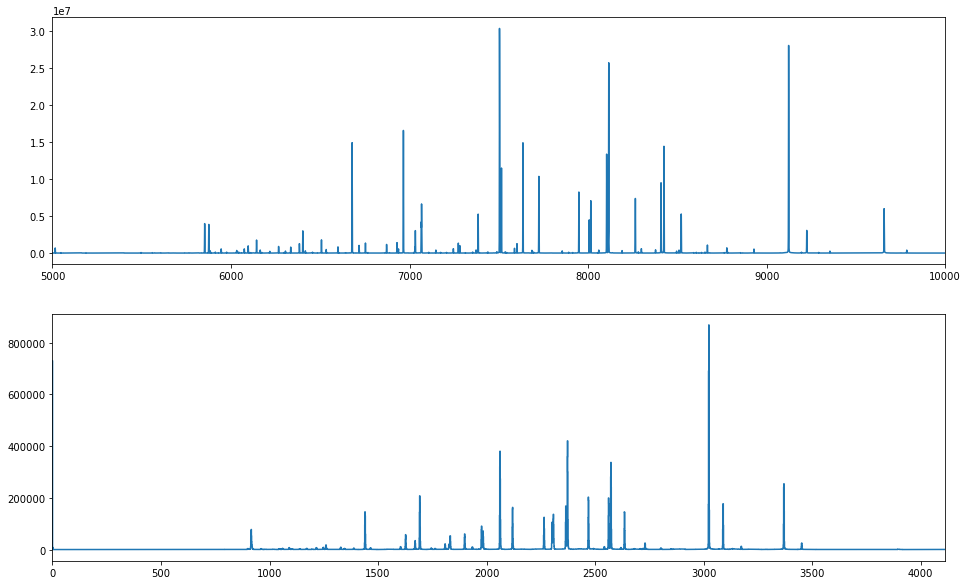

In [18]:
#first graph

#1D spec extraction from atlas lists/specs
fig, (ax1, ax2) = plt.subplots(2,1) #sets up graph dimensions
ax1.plot(redwlnoao, redspecnoao) #plotting wl on x axis, spec?? on y axis
ax1.set_xlim(5000,10000) #sets x axis range

#second graph

#same as above dispersion for 1.5"
#1D spec for arc lamp
#((data) that has overscan subtraction and trimming done to it and image flattened w/ (created above,normalized flat-rnfl), aperaturesize)
rds10 = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage('20170518/red0011.fits').overscan_sub_and_trim().flatten(rnfl), (130, 190))
plt.axes(ax2)
rds10.plot_spec() #orders the 1D spec outputted above and uses plt to plot
print ('for this the goal is to identify the lines in lamp line spectrum?')

In [19]:
#same as for 1.5"

redarcimg10 = reduce_dblspec.DoubleSpecImage('20170518/red0011.fits').overscan_sub_and_trim().flatten(rnfl)
rds10 = reduce_dblspec.DispersionSolution(redarcimg10, (130, 190), poly_order=3)

rds10.guess_line_loc(3372, 9657.78)
rds10.guess_line_loc(3024, 9122.967)
rds10.guess_line_loc(2374, 8115.31)
rds10.guess_line_loc(2063, 7635.1)
rds10.guess_line_loc(1628, 6965.43)

rds10.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 1.0985644639321803, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0038436845920389, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.9303030922578345, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.0642727390202864, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.036360099132756, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 6.580449066077529, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 6.832594622210311, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2336.6905432796366 but i

(16, 112)

top is atlas lines min/maxs and bottom projects those onto arc lamp lines to find matches


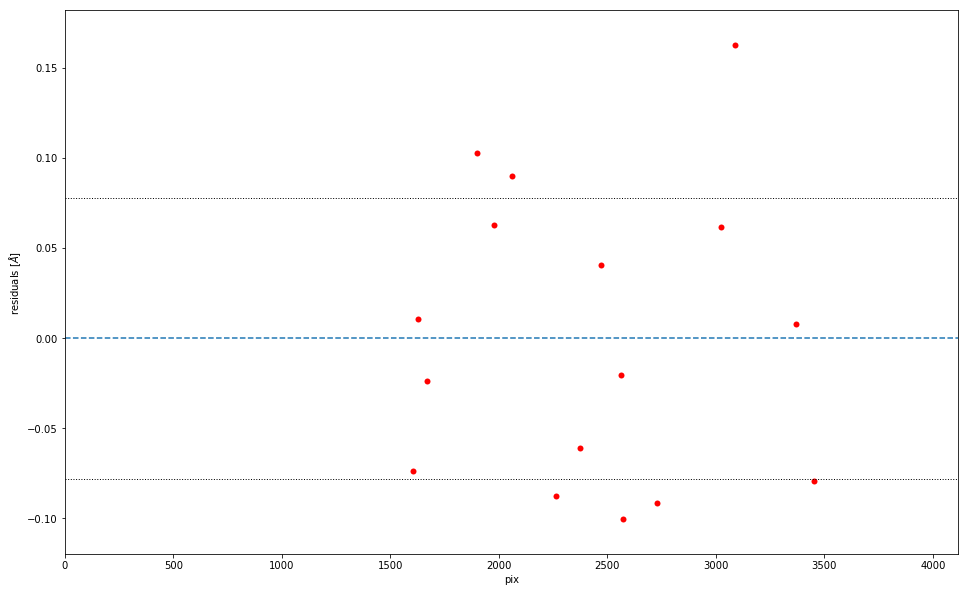

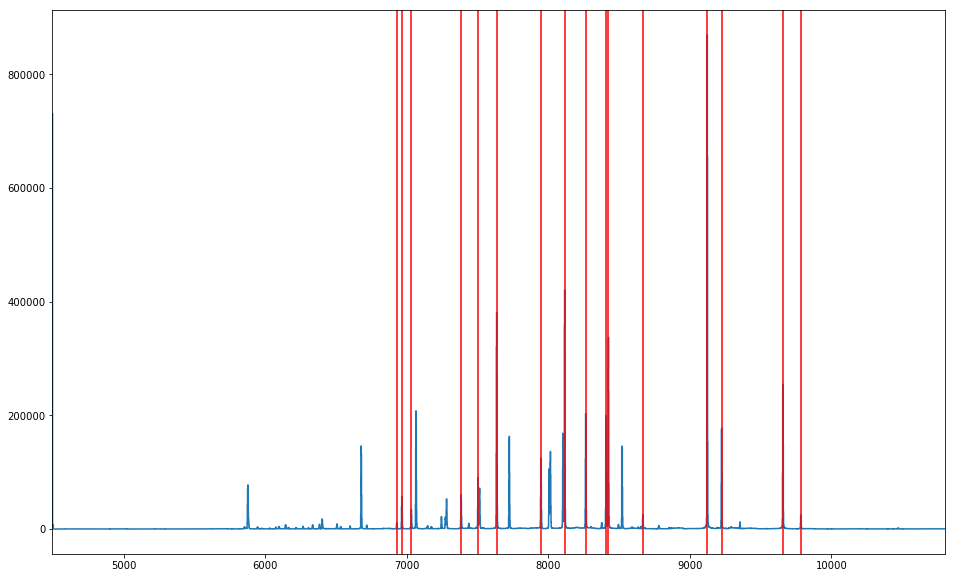

In [20]:
#same as for 1.5"

rds10.plot_solution(True)
plt.figure()
rds10.plot_spec_wl()
print ('top is atlas lines min/maxs and bottom projects those onto arc lamp lines to find matches')

#### Compare the 1.0" and 1.5" solutions 

(1000, 3500)

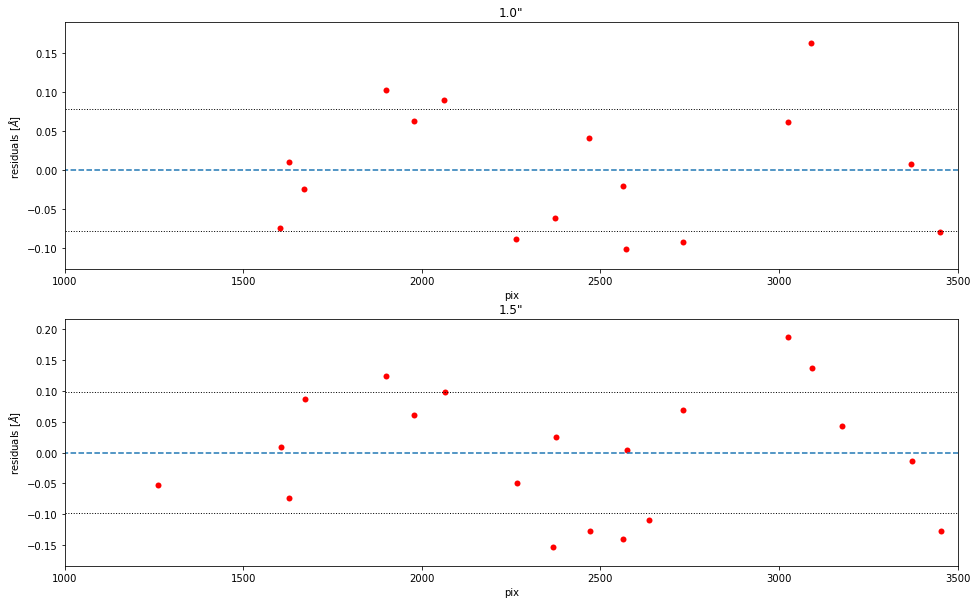

In [21]:
#comparison to see if can use same solution for both slit sizes or just how much change there is?


fix, (ax1, ax2) = plt.subplots(2,1)

#first graph - dispersion solution min/maxs for 1.0"
plt.axes(ax1)
rds10.plot_solution(True)
plt.title('1.0"')
plt.xlim(1000, 3500)

#second graph - dispersion solution min/maxs for 1.5"
plt.axes(ax2)
rds.plot_solution(True)
plt.title('1.5"')
plt.xlim(1000, 3500)

## Blue Dispersion (1.0")

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


these should look similar but they dont and this difference tells us about dispersion - top is atlas, bottom is arc lamp


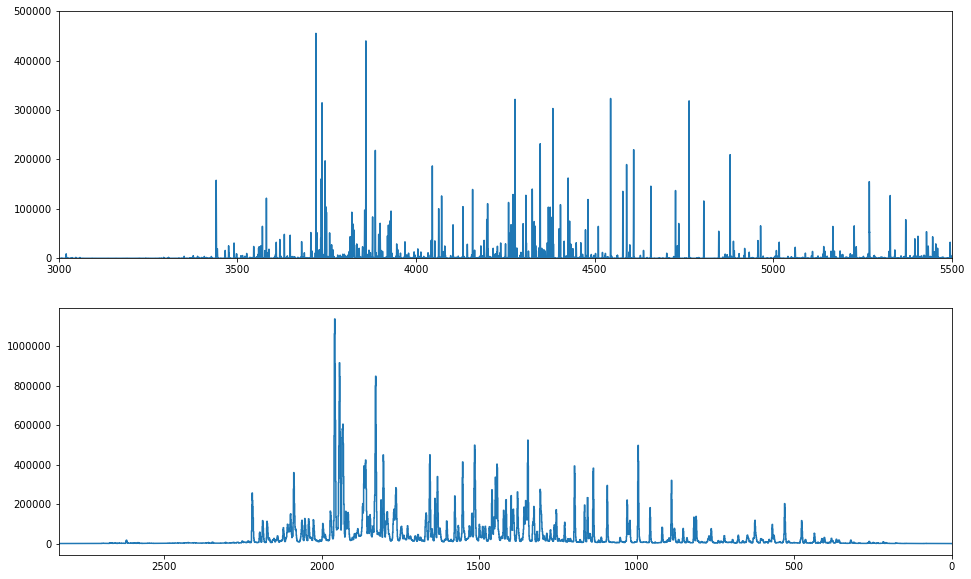

In [22]:
#plotting atlas & arc lamp data just to see it?-verify its ok?

#first graph - atlas lines

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(bluewlnoao, bluespecnoao)
ax1.set_xlim(3000,5500)
ax1.set_ylim(0, 5e5)


#second graph - arc lamp lines

bds10 = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage('20170518/blue0011.fits').overscan_sub_and_trim().flatten(bnfl), (205,260))
plt.axes(ax2)
bds10.plot_spec()
ax2.set_xlim(*ax2.get_xlim()[::-1])

print ('these should look similar but they dont and this difference tells us about dispersion - top is atlas, bottom is arc lamp')

In [23]:
#this was a STEP 3 - that doesnt work b/c cant guess_plot ie give a linear solution with less than 2 points
#this is why needed to do those guess_line_loc in cell below

#px = 1900
#res = guess_plot(px, bds10.pixtowl(px), (bds10, bluewlnoao, bluespecnoao, reduce_dblspec.FEAR_LINE_LIST), 500, 500)
#ax = plt.gcf().axes[0]
#ax.set_xlim(*ax.get_xlim()[::-1])
#res

In [24]:
#match atlas to arc lamp data - via lines peaks to get wavelengths


bluearcimg10 = reduce_dblspec.DoubleSpecImage('20170518/blue0011.fits').overscan_sub_and_trim().flatten(bnfl)
bds10 = reduce_dblspec.DispersionSolution(bluearcimg10, (205, 260), poly_order=3)

bds10.guess_line_loc(1958, 3719.93)
#bds10.guess_line_loc(1828, 3859.9114)
bds10.guess_line_loc(1602, 4103.91)
bds10.guess_line_loc(1550, 4158.59)
bds10.guess_line_loc(1254, 4481.81)
bds10.guess_line_loc(993, 4764.86)
bds10.guess_line_loc(529, 5269.53)

bds10.guess_from_line_list(reduce_dblspec.FEAR_LINE_LIST,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2617.4510074242507 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Tried to find peak at 2614.194109122465 but it's in a valley, not a peak"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 0.9507354917555827, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2591.588510626877 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.728611272165076, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Tried to find peak at 2580.589107615257 but it's in a valley, not a peak"
Failed to find line FeI at wl=3225.785: "Tried to find peak at 2421.67301815243 but it's in a valley, not a peak"
Failed to find line ArII at wl=3243.6887: "Tried to find peak at 2404.6879257861056 but it's in a valley, not a peak"
Failed to find line ArII at wl=3350.9243: "Guessed line's peak

Failed to find line ArII at wl=3946.0971: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line ArI at wl=3948.9789: "Guessed line's peak to base ratio is 2.6304219944069844, which is less than 5"
Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.361028866764175, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.6280945381500822, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.2990012002387603, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.571218523673293, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 2.028214879630224, which is less than 5"
Failed to find line ArII at wl=4042.8937: "Tried to find peak at 1658.8949678348529 but it's in a valley, not a peak"
Failed to find line ArI at wl=4044.

(38, 157)

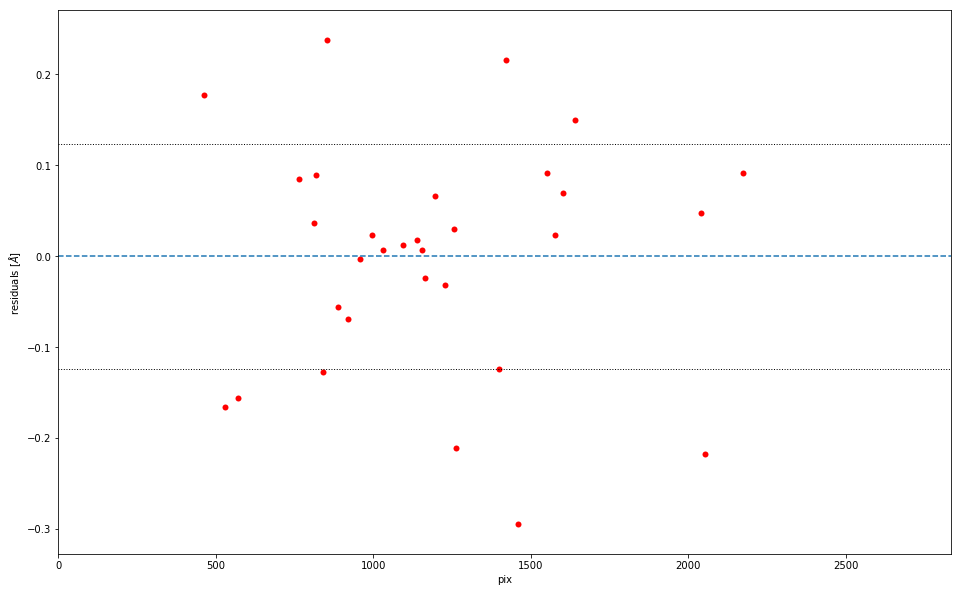

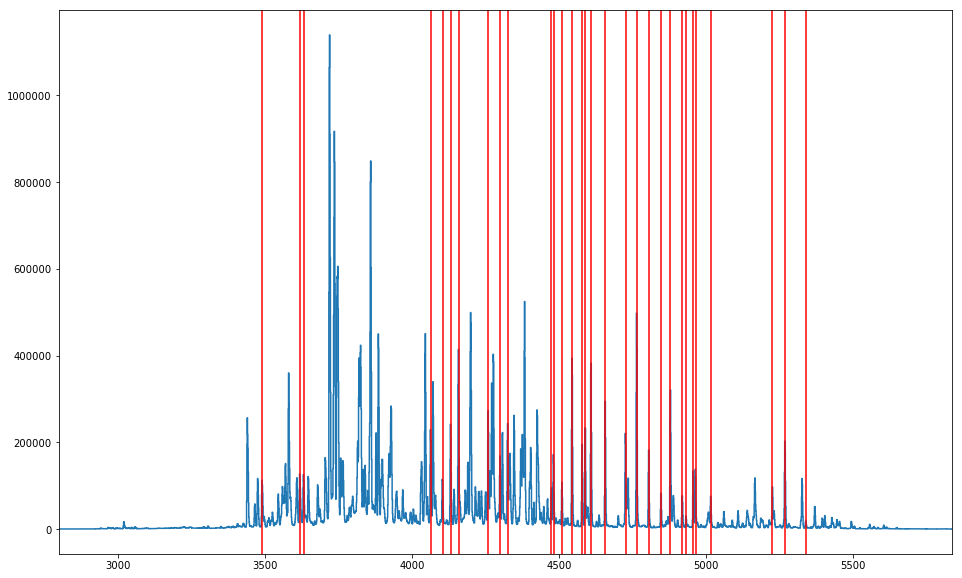

In [25]:
#use matched atlas to arc lamp lines to get pixel correlations

bds10.plot_solution(True)
plt.figure()
bds10.plot_spec_wl()

# Target reductions 

## Ody_nospec 

In [26]:
#Blue side, reduce & combining

#overscan subtraction and flattening(based on normalized flat created earlier) for all ody_nospec
bspecs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(bnfl) 
          for fn in reduce_dblspec.find_all_obj('Ody_nospec','20170518/blue*.fits')]

#stacking all the images taken for that overscanned,flattened target above & calculating new uncertainities, data
#combining to get a stronger detection i imagine
bcomb = reduce_dblspec.combine_imgs(bspecs)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


In [27]:
#exploring combine_imgs to see what its doing

#bspecs is a list of the found 3 images with target name
bspecs

#what is unc in the module -- a parameter (data, unc, header, side)
#bspecs[1].unc #uncertainities (std) by pixel
#bspecs[1].data # array with image data

#help(bspecs[1]) #tells all the parameters, methods for one Dbspec image file

In [28]:
#Red side, reduce & combining

#similar to blue cell above
rspecs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(rnfl) 
          for fn in reduce_dblspec.find_all_obj('Ody_nospec','20170518/red*.fits')]
rcomb = reduce_dblspec.combine_imgs(rspecs)

# LOOK HERE

In [29]:
rcomb

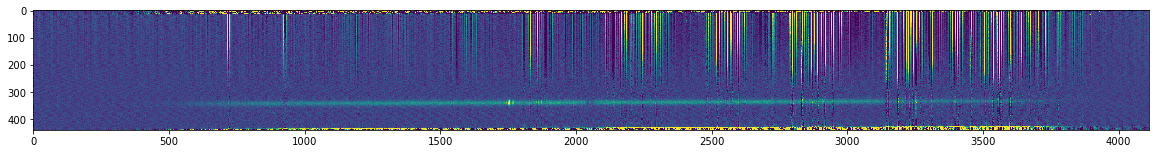

In [36]:
#sky subtraction from 2D image

plt.figure(figsize=(20,10)) #setting up fig size
#not sure how got these values tho..pixels? did look at image & guess?
skyaps = [(280,310),(380,410)] #sky aperatures-part to subtract sky lines from in spatial direction 
#[lower bound pixel location, upper bound pixel location] = (edge of area of targets spectrum)

#this part does sky subtraction from the 2D image of target data
subimg, models = rcomb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
#sky model is one of the defined models in astropy.modeling package - 1D line (slope,intercept); if none then just subtracts mean
#model is what it should look like so removes residuals(sky lines in this case b/c most noise gone in overscan)
#model will fit along the row specified

#plots the sky subtracted, overscanned, combined spectrum for target
#want transpose=false (log=false is default) & must specify vmax/vmin--contrast
subimg.show_image(transpose=False,vmax=40,vmin=-10);

# Questions
#### how are vmax & vmin values determined? and units? (in 'subtract_sky' section: subimg.show_image(vmax=40,vmin=-10)) 
#### is skyaps (sky aperatures) values pixels? -- did you just count them to determine values? 

In [31]:
#exploring sky subtraction code --- still not sure how it works b/c many many 'if's in module but got basic idea

#help(subimg)
#subimg, models #this is output from fitting a linear model to the sky (_linfit)

#type(skyaps[0]) #skyaps is list of 2-tuples

#subimg.show_image(transpose=False,vmax=50,vmin=-50)


# subimg.show_in_ds9() #to use this need a module 'pyds9'

In [32]:
#extracts a 1D spectrum for targets based on sum of fluxes & gives uncertainities


flux, unc = subimg.extract_spectrum((330,350)) #extracts spec using edges of the aperture along the spatial axis


(0, 1430.8019133274843)

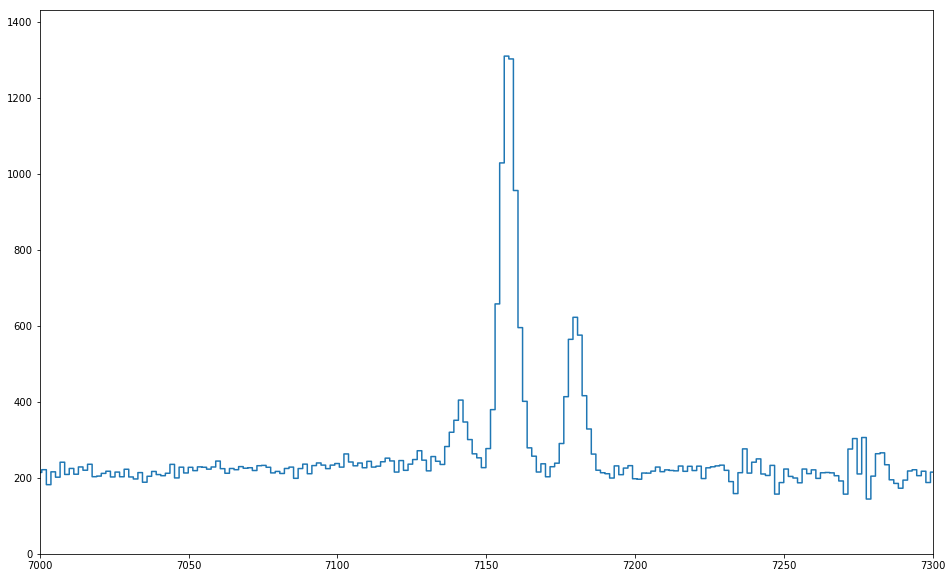

In [33]:
#Red side plotting 1D spectrum

wl = rds.pixtowl(np.arange(len(flux))) #wavelengths determined by arc & dispersion soln - space evenly to length of flux array
plt.step(wl, flux) #plot step line x axis=wavelength, y axis = flux values
plt.xlim(7000, 7300)
plt.ylim(0, plt.ylim()[-1])

(0.09073818522781063,
 0.00033585416399950496,
 <Quantity 27202.62358390464 km / s>,
 <Quantity 9.13611440236551 km / s>)

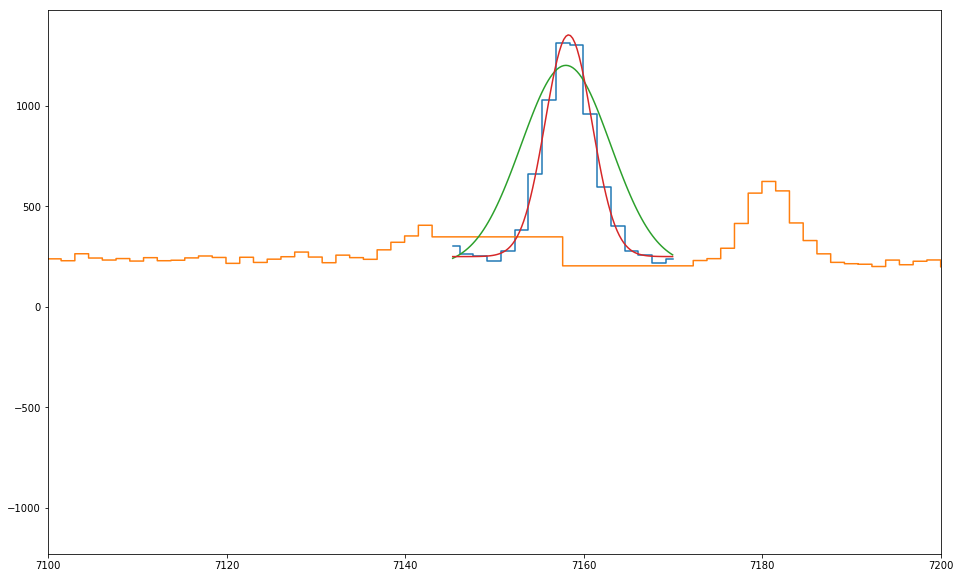

In [34]:
# do a rough *fit* for that line:

#setting up model
line_model0 = modeling.models.Gaussian1D(amplitude=1000, mean=7158, stddev=5) + modeling.models.Const1D(200)
#One dimensional Gaussian model, One dimensional Constant model(amplitude)

fitmsk = (7145<wl)&(wl <7170) #tells range of wavelength peak trying to fit line to
f = modeling.fitting.LevMarLSQFitter() #Levenberg-Marquardt algorithm and least squares statistic line fitter (for curves)
line_model = f(line_model0, wl[fitmsk], flux[fitmsk])#fitting a line based on the models (const&gaussian)

plt.step(wl[fitmsk], flux[fitmsk], where='mid')
plt.step(wl[~fitmsk], flux[~fitmsk], where='mid') #what does ~ do? same as above line otherwise
modwl = np.linspace(wl[fitmsk][0], wl[fitmsk][-1], 100)
plt.plot(modwl, line_model0(modwl))
plt.plot(modwl, line_model(modwl))
plt.xlim(7100,7200)

z = line_model.mean_0.value/6562.8 - 1 #calculating redshift of target
z_percerr = ((line_model.mean_0.value+.2)/6562.8 - 1)/z -1  #.2 is very roughly the RMS error on the dispersion sol'n
v = (z*cnst.c).to('km/s') #velocity
z, z_percerr, v, v*z_percerr #printing out redshift, redshift err, velocity, velocity err?